## **1. Paramètres**

In [20]:
# Importation des bibliothèques
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [21]:
# Définition des chemins de sortie
final_output_path = '../data_final'

if not os.path.exists(final_output_path):
    os.makedirs(final_output_path)

### **2. Calculer la pondération pour les indicateurs socio-économiques**

In [22]:
# Fichiers raster
raster_socioeco = ["../data_final/age_norm.tif",
                   "../data_final/revenu_norm.tif",
                   "../data_final/csp_norm.tif",
                   "../data_final/diplome_norm.tif"]

raster_routes = "../data_final/dist_routes_nommee_norm.tif"
raster_cyclables = "../data_final/dist_pistes_cyclable_norm.tif"

# Valeur NoData définie explicitement
nodata_value = -9999

In [23]:
# Coefficients de pondération pour les indicateurs socio-économiques: Age, Revenu, CSP, Diplome
poids_indicateurs = [0.15, 0.2, 0.27, 0.38]
# Coefficients pour pondérer socioéconomiques + infrastructures
poids_socio = 0.66
poids_infra = 0.33
# Valeur NoData définie explicitement
nodata_value = -9999

## **2. Somme des raster pondérés des indicateurs socio-économiques**

In [24]:
# Ouvrir le premier raster pour récupérer les métadonnées
with rasterio.open(raster_socioeco[0]) as src:
    meta = src.meta
    meta.update(nodata=nodata_value, dtype=rasterio.float32, compress='LZW', predictor=3, tiled=True, blockxsize=256, blockysize=256)

In [25]:
# Créer un tableau pour la somme pondérée des indicateurs socio-économiques
sum_socioeco = np.zeros((meta['height'], meta['width']), dtype=np.float32)

In [26]:
# Parcourir les rasters socio-économiques et appliquer les coefficients
for i, path in enumerate(raster_socioeco):
    with rasterio.open(path) as src:
        data = src.read(1)
        # Remplacer NoData par 0 temporairement
        data = np.where(data == nodata_value, 0, data)
        # Appliquer le coefficient de pondération
        sum_socioeco += data * poids_indicateurs[i]

In [27]:
# Remettre les valeurs NoData
sum_socioeco = np.where(sum_socioeco == 0, nodata_value, sum_socioeco)

# Enregistrer le raster final des indicateurs socio-économiques pondérés
socioeco_output = os.path.join(final_output_path, "socioeco_pondere.tif")
with rasterio.open(socioeco_output, 'w', **meta) as dst:
    dst.write(sum_socioeco, 1)

## **3. Combiner avec les infrastructures pour les deux types de magasins**

In [28]:
# Fonction pour combiner le raster socio-économique pondéré avec un raster d'infrastructure
def raster_combine(socioeco_raster, infra_raster, output_file, poids_socio, poids_infra):
    with rasterio.open(socioeco_raster) as src_socio, rasterio.open(infra_raster) as src_infra:
        # Charger les données
        socioeco_data = src_socio.read(1)
        infra_data = src_infra.read(1)

        # Remplacer NoData par 0 temporairement
        socioeco_data = np.where(socioeco_data == nodata_value, 0, socioeco_data)
        infra_data = np.where(infra_data == nodata_value, 0, infra_data)

        # Appliquer la pondération
        combined_data = socioeco_data * poids_socio + infra_data * poids_infra

        # Remettre NoData
        combined_data = np.where(combined_data == 0, nodata_value, combined_data)

        # Atualizar meta com compressão LZW
        meta = src_socio.meta
        meta.update(compress='LZW', predictor=3, tiled=True, blockxsize=256, blockysize=256)

    # Enregistrer le raster combiné avec compression
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(combined_data, 1)
    print(f"Raster pondéré pour infrastructure sauvegardé: {output_file}")

In [29]:
# Créer les deux rasters combinés pour les types de magasins
raster_combine(socioeco_output, raster_routes, f"{final_output_path}/biocoop_grande_surf.tif", poids_socio, poids_infra)
raster_combine(socioeco_output, raster_cyclables, f"{final_output_path}/biocoop_petite_surf.tif", poids_socio, poids_infra)


Raster pondéré pour infrastructure sauvegardé: ../data_final/biocoop_grande_surf.tif
Raster pondéré pour infrastructure sauvegardé: ../data_final/biocoop_petite_surf.tif


## **4. Visualiser le raster pondéré final**

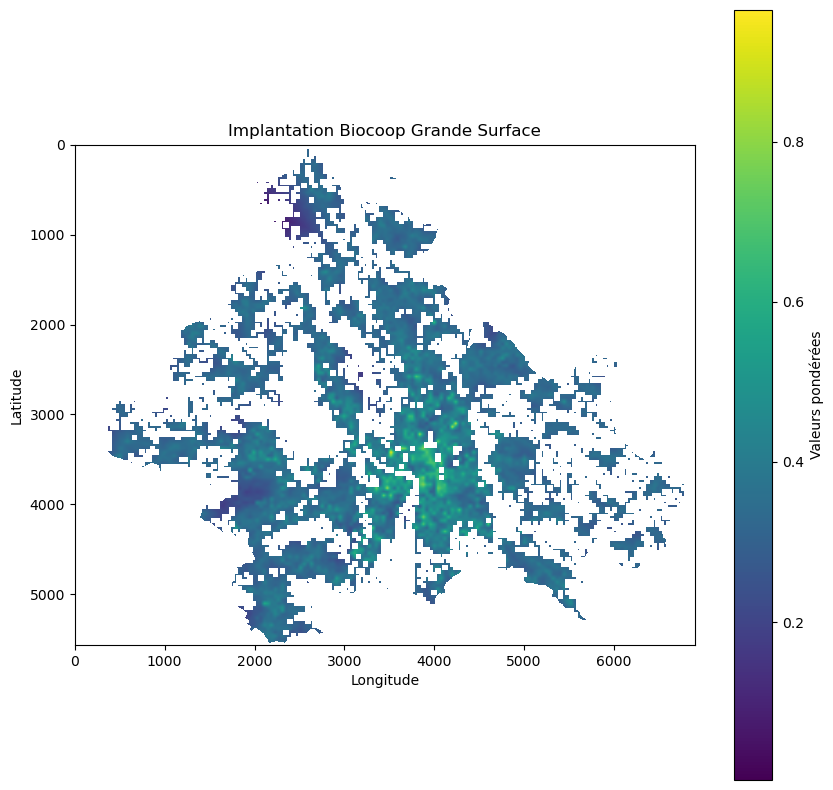

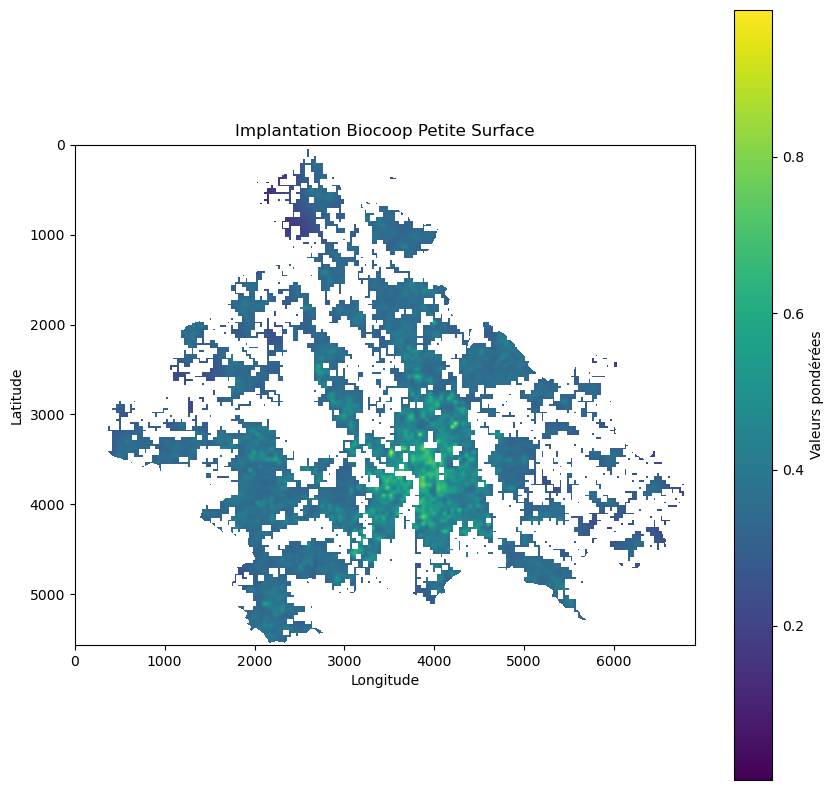

In [30]:
def afficher_raster(raster_path, titre):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        # Remplacer NoData par NaN pour afficher les zones sans données comme transparentes
        data = np.where(data == nodata_value, np.nan, data)

        # Affichage
        plt.figure(figsize=(10, 10))
        plt.imshow(data, cmap='viridis', vmin=np.nanmin(data), vmax=np.nanmax(data))
        plt.colorbar(label='Valeurs pondérées')
        plt.title(titre)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

# Afficher les deux rasters finaux
afficher_raster(f"{final_output_path}/biocoop_grande_surf.tif", "Implantation Biocoop Grande Surface")
afficher_raster(f"{final_output_path}/biocoop_petite_surf.tif", "Implantation Biocoop Petite Surface")